In [1]:
#  Installation of the following additional packages
!pip install transformers
!pip install datasets

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 33.8 MB/s 
     |████████████████████████████████| 895 kB 32.8 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 3.3 MB 27.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 306 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 243 kB 49.1 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 
     |████████████████████████████████| 192 kB 49.2 MB/s 
     |████████████████████████████████| 160 kB 53.3 MB/s 


In [12]:
!pip3 install tensorflow

In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [3]:
encoded_input = tokenizer(["Hello, I'm a single sentence! Thist great.","I linke it. At the most."],
                          ["test bacht2. test", "test2. test"])
print(encoded_input)

{'input_ids': [[101, 8667, 117, 146, 112, 182, 170, 1423, 5650, 106, 1188, 1204, 1632, 119, 102, 2774, 171, 7291, 1204, 1477, 119, 2774, 102], [101, 146, 5088, 1162, 1122, 119, 1335, 1103, 1211, 119, 102, 2774, 1477, 119, 2774, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [5]:
import numpy
import pandas as pd
data = pd.read_csv("OnionOrNot.csv", encoding="UTF-8")

In [7]:
data.head()

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1


In [8]:
# Split the data into two pieces, one for training and one for testing
from sklearn.model_selection import train_test_split
train_text_series , test_text_series, train_label_series, test_label_series = train_test_split(data["text"], data["label"], test_size = 0.30, random_state = 42)

# Split the training data set again to additionally get a validation data set for tuning the hyper parameters of the model
#train_text_series, valid_text_series, train_label_series, valid_label_series = train_test_split(train_text_series, train_label_series, test_size = 0.177, random_state = 42)

# Casting the data from series objects into lists (as expected from the tokenizer function below)
train_text = train_text_series.to_list()
#valid_text = valid_text_series.to_list()
test_text = test_text_series.to_list()
train_label = train_label_series.to_list()
#valid_label = valid_label_series.to_list()
test_label = test_label_series.to_list()

# Sample sizes
print("Size of the training dataset: ", len(train_text))
#print("Size of the validation dataset: ", len(valid_text))
print("Size of the test dataset: ", len(test_text))

Size of the training dataset:  16800
Size of the test dataset:  7200


In [9]:
from transformers import AutoTokenizer
import numpy as np

# Definition of the model that will be fine-tuned
#checkpoint = "bert-base-german-cased"
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
# Getting the tokenizer for the defined model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Getting the encodings (as tensors for tensorflow) for the texts for training, validation, and testing
train_encodings = dict(tokenizer(train_text, padding=True, truncation=True, return_tensors='np'))
#valid_encodings = dict(tokenizer(valid_text, padding=True, truncation=True, return_tensors='np'))
test_encodings = dict(tokenizer(test_text, padding=True, truncation=True, return_tensors='np'))

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [10]:
type(tokenizer(train_text, padding=True, truncation=True, return_tensors='np'))

transformers.tokenization_utils_base.BatchEncoding

In [11]:
# Calculation of class weights to account for the unbalanced sizes of the classes

unique, counts = numpy.unique(train_label, return_counts=True)
print("Class Frequencies: ", dict(zip(unique, counts)))

class_weight = {0: counts[1]/counts[0], 1: 1.0}
print("Class Weights: ", class_weight)

Class Frequencies:  {0: 10423, 1: 6377}
Class Weights:  {0: 0.6118200134318335, 1: 1.0}


In [14]:
# Import of all needed functions and packages
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#from utils import F1_metric


# Definition of batch size and number of epochs
batch_size = 8
num_epochs = 3

# Definition of the learning rate scheduler
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied by the total number of epochs
num_train_steps = (len(train_label) // batch_size) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0., decay_steps=num_train_steps)

# Definition of the optimizer using the learning rate scheduler
opt = Adam(learning_rate=lr_scheduler)

# Definition of the model architecture and initial weights
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
# Definition of the loss function
loss = SparseCategoricalCrossentropy(from_logits=True)
# Definition of the full model for training (or fine-tuning)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [15]:
num_train_steps

6300

In [16]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.layers[0].trainable=False

In [18]:
model.fit(
    train_encodings,
    np.array(train_label),
    #validation_data=(valid_encodings, np.array(valid_label)),
    class_weight=class_weight,
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/3
2100/2100 [==============================] - 738s 347ms/step - loss: 0.2420 - accuracy: 0.8691
Epoch 2/3
2100/2100 [==============================] - 728s 347ms/step - loss: 0.0821 - accuracy: 0.9639
Epoch 3/3
2100/2100 [==============================] - 728s 346ms/step - loss: 0.0178 - accuracy: 0.9940


In [19]:
# After fine-tuning you might want to save the model to re-use it later
model.save_pretrained("distilbert_fineTuned_onionOrNot.tf")

In [20]:
# To load an already fine-tuned model to directly use it
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert_fineTuned_onionOrNot.tf")

Some layers from the model checkpoint at distilbert_fineTuned_onionOrNot.tf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_fineTuned_onionOrNot.tf and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
import tensorflow as tf
# Calculation of the probabilities for each class
# There is no softmax layer at the top of the models in Hugging Face, therefore
# the probabilities have to be calculated here using the softmax function
test_pred_prob = tf.nn.softmax(model.predict(dict(test_encodings))['logits'])

# Extraction of the respective class number with the highest probability
test_pred_class = np.argmax(test_pred_prob, axis=1)

In [22]:
# Checking the test data results

from sklearn import metrics

# Mean accuracy
print("Mean Accuracy:\n", metrics.accuracy_score(test_label, test_pred_class))

# Confusion matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(test_label, test_pred_class))

# F1 Score
print("F1 Score:\n", metrics.f1_score(test_label, test_pred_class))

# Precision
print("Precision:\n", metrics.precision_score(test_label, test_pred_class))

# Recall
print("Recall:\n", metrics.recall_score(test_label, test_pred_class))

# ROC AUC Score
print("ROC AUC:\n", metrics.roc_auc_score(test_label, test_pred_class))

# Cohen's Kappa Score
print("Cohen's Kappa:\n", metrics.cohen_kappa_score(test_label, test_pred_class))

# Quadratic Weighted Kappa Score
print("Quadratic Weighted Kappa:\n", metrics.cohen_kappa_score(test_label, test_pred_class,weights='quadratic'))

Mean Accuracy:
 0.9227777777777778
Confusion Matrix:
 [[4302  275]
 [ 281 2342]]
F1 Score:
 0.8938931297709924
Precision:
 0.8949178448605273
Recall:
 0.8928707586732749
ROC AUC:
 0.9163938674292744
Cohen's Kappa:
 0.8331945649229071
Quadratic Weighted Kappa:
 0.8331945649229071


In [23]:
# Number of answers classified with >95% or <1%
high_probs = np.logical_or(np.asarray(test_pred_prob)[:,0]>=.95,np.asarray(test_pred_prob)[:,0]<=.05)
unique, counts = numpy.unique(high_probs, return_counts=True)
dict(zip(unique, counts))

{False: 579, True: 6621}

In [25]:
np.histogram(test_pred_prob[:,0])

(array([2422,   73,   50,   33,   39,   36,   33,   46,  100, 4368]),
 array([7.7715245e-05, 9.9994518e-02, 1.9991133e-01, 2.9982814e-01,
        3.9974493e-01, 4.9966174e-01, 5.9957856e-01, 6.9949538e-01,
        7.9941213e-01, 8.9932895e-01, 9.9924576e-01], dtype=float32))

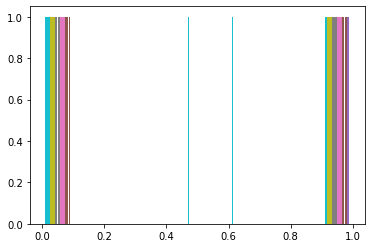

In [24]:
import matplotlib.pyplot as plt

plt.hist(test_pred_prob, bins = 10)
plt.show()

In [26]:
probs_misclassifieds = test_pred_prob[:,0][(test_label-test_pred_class)!=0]
print(np.histogram(probs_misclassifieds))

(array([190,  30,  21,  12,  22,  12,  12,  18,  36, 203]), array([7.7715245e-05, 9.9985600e-02, 1.9989349e-01, 2.9980138e-01,
       3.9970925e-01, 4.9961716e-01, 5.9952503e-01, 6.9943291e-01,
       7.9934084e-01, 8.9924872e-01, 9.9915659e-01], dtype=float32))


In [ ]:
np.asarray(test_text)[np.logical_and(np.asarray(test_label)==0, test_pred_class==1)]

In [ ]:
np.asarray(test_pred_prob)[np.logical_and(np.asarray(test_label)==0, test_pred_class==1)][:,0]


In [29]:
np.asarray(test_text)[np.logical_and(np.asarray(test_label)==1, test_pred_class==0)]

array(['White House Raises Official Hurricane Florence Death Toll To -17',
       'Cuban Army Honors Fidel Castro With 21-Gun Firing Squad',
       'Study: Most Serial Killers Did Not Receive Toy Every Time They Went To Store As Kids',
       'Kamala Harris Undergoes Heart Surgery After Seeing Positive Reception For Sanders',
       'Ryan Lochte Admits Olympic Pool Much Wetter Than He Remembered',
       'Scientists Confirm Anti-Vaccine Sites Contain No Facts',
       'We Challenged This Man To Survive On Minimum Wage And He Immediately Got Hit By A Car',
       'Expert On International Jewish Conspiracy Has Never Been More Than 40 Miles Outside Council Bluffs, Iowa',
       'Controversial ‘Heartbeat Bill’ Passes In Ohio',
       'They Spelled It ‘Sean’: How One Barista Destroyed This Man’s Morning',
       'Dozens Of Other Countries That Interfered In 2016 Election Annoyed Russia Getting All The Credit',
       'Hitman 2’s New Tropical Resort DLC Lets You Quit Being An Assassin And Be

In [30]:
np.asarray(test_pred_prob)[np.logical_and(np.asarray(test_label)==1, test_pred_class==0)][:,1]


array([0.09694139, 0.19463617, 0.07917065, 0.20952986, 0.13992035,
       0.18316747, 0.13407716, 0.00382133, 0.00214897, 0.44345424,
       0.00507024, 0.01679813, 0.11594613, 0.00585829, 0.02125465,
       0.00207801, 0.00326213, 0.28138313, 0.1707031 , 0.35373148,
       0.0194437 , 0.00439824, 0.14642054, 0.00183351, 0.1629484 ,
       0.10023122, 0.18592165, 0.01048119, 0.00166979, 0.00180233,
       0.01724258, 0.06780416, 0.03511009, 0.26776043, 0.00120973,
       0.31772244, 0.00124791, 0.04841068, 0.12829031, 0.0116214 ,
       0.04112949, 0.01005609, 0.01186117, 0.00708137, 0.22177611,
       0.00122613, 0.00259458, 0.00135364, 0.4745119 , 0.00775336,
       0.00514959, 0.00250414, 0.07956803, 0.00337626, 0.46161366,
       0.1348773 , 0.00190745, 0.03015165, 0.01190585, 0.434487  ,
       0.00094614, 0.00688246, 0.16580862, 0.00717301, 0.00311563,
       0.16889092, 0.3059283 , 0.00191638, 0.2574993 , 0.16880333,
       0.01947088, 0.05952797, 0.00128785, 0.14313164, 0.00897